In [168]:
### Benjamin Tollison ###
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
from IPython.display import Latex, Math, display
from scipy.optimize import curve_fit
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from decimal import Decimal
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi

In [169]:
area_throat = 0.042
area_exit = 4.91
radius_throat = (area_throat/np.pi)**0.5
radius_exit = (area_exit/np.pi)**0.5
displayVariableWithUnits('r_{throat}',radius_throat,'m')
displayVariableWithUnits('r_{exit}',radius_exit,'m')
scaling_factor = radius_throat/17

<IPython.core.display.Math object>

<IPython.core.display.Math object>

0.041999999999999996
4.900214208477508
0.0
2.4077092957523676


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

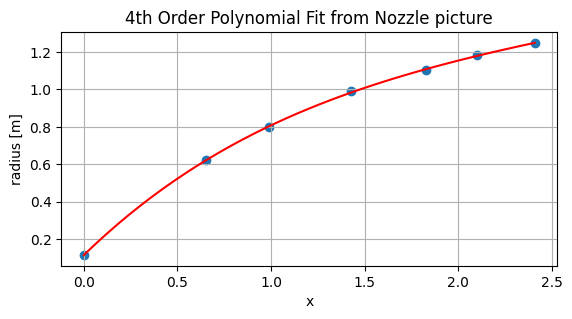

In [170]:
# Define your data points (x, y)
scaling_factor = radius_throat/17
x_data = (np.array([210,306,355,420,479,519,564]) - 210)*scaling_factor
y_data = np.array([17,65*1.4125,83*1.4125,103*1.4125,115*1.4125,123*1.4125,130*1.4125])*scaling_factor
print(np.pi*y_data[0]**2)
print(np.pi*y_data[-1]**2)
print(x_data[0])
print(x_data[-1])
# Define the 4th order polynomial function
def fourth_order_poly(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

params, covariance = curve_fit(fourth_order_poly, x_data, y_data)
a_fit, b_fit, c_fit, d_fit, e_fit = params
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = fourth_order_poly(x_fit, a_fit, b_fit, c_fit, d_fit, e_fit)
figure,axis = plt.subplots()
plt.plot(x_fit, y_fit, color='red', label='Fitted Curve')
plt.scatter(x_data, y_data, label='Data')
plt.xlabel('x')
plt.ylabel('radius [m]')
plt.title('4th Order Polynomial Fit from Nozzle picture')
plt.grid(True)
axis.set_aspect('equal')
displayVariable('a',a_fit)
displayVariable('b',b_fit)
displayVariable('c',c_fit)
displayVariable('d',d_fit)
displayVariable('e',e_fit)

### Here is how I can find all the mach values from the area equation
$$\frac{\sigma}{\sigma_{cr}} = 
\frac{1}{M} \left[\frac{2}{\gamma+1}\left(1+\frac{\gamma-1}{2}M^2\right)\right]^\frac{\gamma+1}{2(\gamma-1)}$$
We can us Householder's second order root method from the nasa report:\
https://www.grc.nasa.gov/www/winddocs/utilities/b4wind_guide/mach.html
$$ x_{i+1} = x_i - \frac{2f}{f'-\sqrt{f'^2-ff''}}$$
With the subsonic regime being defined by:
$$f = (P+QX)^\frac{1}{Q} - RX = 0$$
$$f' = (P+QX)^{\frac{1}{Q}-1} - R$$
$$f'' = P(P+QX)^{\frac{1}{Q}-2}$$
and the supersonic regime can be found with the following:
$$f = (PX+Q)^\frac{1}{P} - RX = 0$$
$$f' = (PX+Q)^{\frac{1}{P}-1} - R$$
$$f'' = Q(PX+Q)^{\frac{1}{P}-2}$$
And the Coefficients can be defined by:
$$P=\frac{2}{\gamma+1}$$
$$Q = \frac{\gamma-1}{\gamma+1}=1-P $$
$$X_{subsonic} = M^2$$
$$X_{supersonic} = \frac{1}{M^2}$$
$$R_{subsonic} = \left(\frac{\sigma}{\sigma_{cr}}\right)^2$$
$$R_{supersonic} = \left(\frac{\sigma}{\sigma_{cr}}\right)^\frac{2Q}{P}$$
Therefore we can have 4 possible solutions. Subsonic->subsonic, subsonic->supersonic, supersonic->subsonic, or supersonic->supersonic

In [171]:
def HouseholdP2(x_intial:float,scheme_function,scheme_prime,scheme_double_prime)->float:
  max_iterations = 1000
  while abs(scheme_function(x_intial)) > 1e-8:
    x_intial = x_intial - ((2*scheme_function(x_intial))/(scheme_prime(x_intial) - (scheme_prime(x_intial)**2-scheme_function(x_intial)*scheme_double_prime(x_intial))**0.5))
    max_iterations -=1
    if max_iterations ==0:
      print('The scheme didn\'t converge')
      break
  return x_intial
def Householder(x_position:float,section_supersonic:bool,area_function)->float:
  gamma = 1.24
  P = 2/(gamma+1)
  Q = 1-P
  if section_supersonic==False:
    R = (area_function(x_position))**2
    a = P**(1/Q)
    r = (R-1)/(2*a)
    x_intial = 1 / ((1+r)+np.sqrt(r*(r+2)))
    f = lambda X : (P+Q*X)**(1/Q) - R*X
    f_prime = lambda X: (P+Q*X)**((1/Q)-1) - R
    f_double_prime = lambda X: P*(P+Q*X)**((1/Q)-2)
    x_final = HouseholdP2(x_intial,f,f_prime,f_double_prime)
    return (x_final)**0.5
  if section_supersonic == True:
    R = (area_function(x_position))**(2*Q/P)
    a = Q**(1/P)
    r = (R-1)/(2*a)
    x_intial = 1 / ((1+r)+np.sqrt(r*(r+2)))
    f = lambda X : (P*X+Q)**(1/P) - R*X
    f_prime = lambda X: (P*X+Q)**((1/P)-1) - R
    f_double_prime = lambda X: Q*(P*X+Q)**((1/P)-2)
    x_final = abs(HouseholdP2(x_intial,f,f_prime,f_double_prime))
    return 1/(x_final)**0.5
original_geometry = lambda x: (np.pi*(a_fit*x**4 + b_fit*x**3 + c_fit*x**2 + d_fit*x + e_fit)**2)/(np.pi*radius_throat**2)
mach_values = {'SubsonicOnly':[],'Subsonic/Supersonic':[],'Supersonic/Subsonic':[],'SupersonicOnly':[]}
area_ratio = {'Area/Area_cr':[]}
x_values = np.linspace(min(x_data),max(x_data),100)
area_ratio['Area/Area_cr'] = [original_geometry(x) for x in x_values]
mach_values['SubsonicOnly'] = [Householder(x,False,original_geometry)for x in x_values]
mach_values['Subsonic/Supersonic'] = [Householder(x,False,original_geometry)for x in x_values]
mach_values['Supersonic/Subsonic'] = [Householder(x,True,original_geometry)for x in x_values]
mach_values['SupersonicOnly'] = [Householder(x,True,original_geometry)for x in x_values]
display(pd.DataFrame(area_ratio))
displayVariable('M^*',mach_values['SupersonicOnly'][0])
displayVariable('M_e',mach_values['SupersonicOnly'][-1])

,Area/Area_cr
0,1.002898
1,1.448908
2,1.967129
3,2.553639
4,3.204665
...,...
95,112.788530
96,113.776514
97,114.759831
98,115.738639


<IPython.core.display.Math object>

<IPython.core.display.Math object>

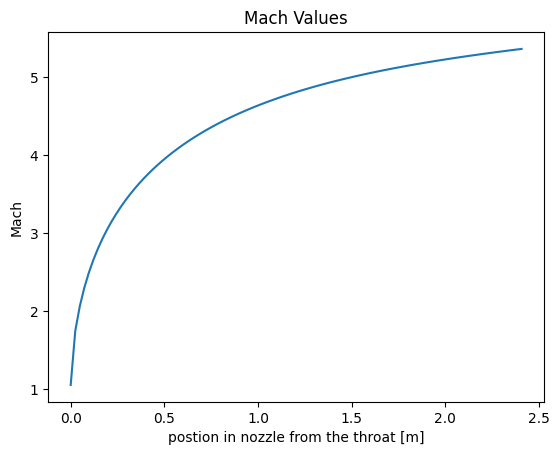

In [172]:
plt.plot(x_values,mach_values['SupersonicOnly'])
plt.title('Mach Values')
plt.ylabel('Mach')
plt.xlabel('postion in nozzle from the throat [m]')
plt.show()

To find the stagnation pressure ratio as a function of mach, I used the following equation:
$$\frac{P_0}{P} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{\gamma-1}$$
$$\Rightarrow \frac{P}{P_0} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{1-\gamma}$$